## Einference

### The problem...

Given data
$$
y_j= p(x_j)+\eta_j ~~~x_j\in (0,1),~~j\in\{1,\dots,J\}
$$

$$\eta_j\sim\mathcal{N}(0,\gamma^2)~~{\rm i.i.d.}$$

with $p$ satisfying
$$\frac{{\rm d}}{{\rm d} x}\big( {\color{red}u}\frac{{\rm d}p}{{\rm d} x} \big) =1,\quad x\in (0,1)$$

$$p(0)=0, p(1)=1,$$

estimate ${\color{red}u}\in X={\color{mgray}\{w\in C^1(0,1): \inf_{(0,1)}w>0\}}$.



### Likelihood

Let $G_j: u\mapsto p(x_j)$. Then $\mu$ satisfying
$$
\frac{{\rm d}\mu}{{\rm d} \mu_0}(u) \propto \exp\Big( - \frac{1}{2\gamma^2}\sum_{j=1}^J |y_j-G_j(u)|^2    \Big)
$$
is well-defined for $\mu_0(X)=1$.


### Prior
$\mu_0$ defined through
$$
u = g\big(\sum_{j\in \mathbb N} {\alpha_j\,\xi_j}\;\psi_j(x)\big)
$$
for $u\sim\mu_0$ and with


$\big\{\psi_j(x)\big\}_{j\in\mathbb N}=\big\{1, \sqrt{2}\,\cos(2k\pi x),\sqrt{2}\,\sin(2k\pi x)\big\}_{k\in\mathbb N}$


$c_1 j^{-s}\le \alpha_j \le c_2 j^{-s}$, $s>3/2$, (to ensure $u\in C^1(0,1)$)

$\xi_j\sim\cal{N} \rm{(0,1)~~i.i.d.}$
 
$g(\cdot)=c\exp(\cdot)$ (to impose positive lower bound on $u(x)$)


### Forward solution of the PDE

Integrating with respect to $x$ gives
\begin{align*}
u(x)\frac{{\rm d}p(x)}{{\rm d} x}=x+C
\end{align*}
with $C\in{\mathbb R}$ constant.

Integrating once more and noting that $p(0)=0$ gives
\begin{align*}
p(x)=\int_0^x \frac{y+C}{u(y)}\,{\rm d} y
\end{align*}
where by $p(1)=1$ we have
$$
C=\frac{1}{ \int_0^1\frac{1}{u(y)}\,{\rm d} y}\Big(1-\int_0^1 \frac{y}{u(y)}\,{\rm d} y\Big)
$$

In [1]:
'''
import libraries
'''
import numpy as np
from matplotlib import pyplot as plt
#from EllipticPDE import Elliptic1D, g
#from MCMC import *

np.random.seed(19)

### Define functions: Elliptic PDE (in 1D)

In [2]:
class Elliptic1D():
    def __init__(self, s=3, nPrior=40, gamma=0.01, ndata=100):

        # space grid
        self.Nx = 1000
        self.x = np.linspace(0, 1, endpoint=True, num=self.Nx + 1)

        # truth....
        self.U = lambda x: (np.sin(np.pi*x)+1)/2 #(x+1)**2 * (2-x)**3/8
        
        # noise sd
        self.gamma=gamma

        # data points (y_i, i=1,...,ndata)
        self.ndata = ndata
        self.data = np.zeros((ndata,2))
        self.data[:,0] = np.linspace(1/(ndata+1), 1, ndata, endpoint=False)
        self.ptruth = self.pEval(self.U)
        noise = np.random.normal(loc=0.0, scale=self.gamma, size=ndata)
        self.data[:,1] = np.interp(self.data[:,0], xp=self.x, fp=self.ptruth) + noise

        # prior 
        self.s = s
        self.nPrior = nPrior

    def pEval(self, u):
        """
        Calculates function p, soln of d/dx(u dp/dx) = 1, x\in (0,1)
        with p(0)=0, p(1)=1
        """
        x = np.linspace(0, 1, self.Nx+1, endpoint=True)
        c = 1
        I1 = 1/u(x)
        I2 = c*x/u(x)
        c1 = (1-IntTrap(x, I2))/ IntTrap(x, I1)
        sol = np.zeros(self.Nx+1)
        sol[0] = 0
        sol[-1] = 1
        for i in range(self.Nx-1):
            sol[i+1] = IntTrap(x[:i+2], (c1+c*x[:i+2])/u(x[:i+2]))
        return sol

    def negll(self, xiu):
        """
        Evaluates negative log likelohood at u, that is |y-G(u)|^2/(2\gamma^2)
        """
        u = lambda x: g(self.prior(x, xi=xiu))
        pu = np.interp(self.data[:,0], xp=self.x, fp=self.pEval(u))
        return np.sum((self.data[:,1] - pu)**2)/(2*self.gamma**2)

    def prior(self, x, xi):
        """
        Evaluate the random se trajectories at x
        """
        n = int(xi.size/2)
        N = np.arange(0, n)
        gammaN = 1 / (N + 1) ** self.s
        X, N = np.meshgrid(x, N)
        cos = np.sum((xi[:n] * gammaN)[:, np.newaxis] * np.sqrt(2) * np.cos(2 * np.pi * X * N), axis=0)
        sin = np.sum((xi[n:] * gammaN)[:, np.newaxis] * np.sqrt(2) * np.sin(2 * np.pi * X * N), axis=0)
        return sin + cos

    def omf(self, nll, xiu):
        """
        Compute the Onsager–Machlup function
        """
        res = nll #self.negLL(xiu)
        res += 0.5 * np.sum(xiu ** 2)
        return res
    
def g(x):
    """
    Imposing positive lower bound
    """
    #c = 1
    #g =(x>=c)*x/1 + c*(x<c)/(1+c-x)
    g = np.exp(x)/3
    return g


def IntTrap(t, fn):
    """
    Integrating fn using trapezoidal rule
    """
    return (fn[1:-1].sum() + (fn[0] + fn[-1]) / 2) * np.diff(t)[0]

### Define functions: MCMC

In [3]:
import timeit

class MC():
    
    def __init__(self, negll):

        # Negative log-likelihood
        self.negll = negll


    def MCMC(self, u0, h, n):
        '''
        Run the MCMC algorithm with Metropolis-Hastings
        '''
        print('Running MCMC MH sampling')
        print('# of total samples: ', n)

        # Initialization
        proba = 0.0
        results = np.zeros((n+1, u0.size+1))
        self.ui = u0
        self.nll = self.negll(self.ui)
        results[0, :] = np.hstack((self.nll, self.ui))

        proposal = self.pCN_proposal

        print('Initial nll', results[0, 0])
        tic = timeit.default_timer()

        for j in range(n):
            acpt = proposal(h)
            proba += acpt / n
            print('draw no.', j, self.nll)
            results[j + 1, :] = np.hstack((self.nll, self.ui))

        toc = timeit.default_timer()
        print('Run time is', toc - tic)
        print('Probability', proba)

        return proba, results

    def pCN_proposal(self, h):
        '''
        preconditioned Crank-Nicolson proposal
        '''
        xi = np.random.randn(self.ui.size)
        up = np.sqrt(1-h**2)*self.ui + h*xi

        # Likelihood ratio
        nll = self.negll(up)

        # Phi(u)-Phi(v)
        log_ratio = self.nll - nll

        acpt = (np.random.rand() <= np.minimum(1, np.exp(log_ratio)))
        if (acpt == 1):
            self.nll = nll
            self.ui = up
        return acpt

In [4]:
def post_results(results, nburn, nskip):
    """
    Post treatment of MCMC results; disregard burn-in period (nburn); thin sample (nskip)
    """
    ntot = results.shape[0]-1
    idx = (nburn + np.arange(0, ntot+1-nburn, nskip)).astype(int)
    keep = results[idx, :].copy()
    return keep

def plot_results(results, N=3):
    """
    Plot evolution of NLL and u ('trace plots')
    """
    f, axarr = plt.subplots(3+N, sharex=True)
    axarr[0].plot(results[:, 0])
    axarr[0].set_ylabel(r'$\Phi(u;y)$')
    axarr[1].plot(results[:, 1])
    axarr[1].set_ylabel(r'$\xi_0$')
    axarr[2].plot(results[:, 2])
    axarr[2].set_ylabel(r'$\xi_1$')
    axarr[3].plot(results[:, 3])
    axarr[3].set_ylabel(r'$\xi_2$')
    axarr[4].plot(results[:, 4])
    axarr[4].set_ylabel(r'$\xi_3$')
    axarr[5].plot(results[:, 5])
    axarr[5].set_ylabel(r'$\xi_4$')
    plt.xlim(0, results[:, 0].size)
    plt.xlabel("Steps")
    plt.show()

def keep_MAP(keep):
    """
    Get the maximum a posteriori probability (MAP) estimate from the sample
    """
    omf = PDE.omf(keep[0,0], keep[0, 1:])
    MAP = keep[0, :]
    for i in range(keep.shape[0]):
        omfn = PDE.omf(keep[i,0], keep[i, 1:])
        if (omfn < omf):
            omf = omfn.copy()
            MAP = keep[i, :]
    return MAP[1:]

def u_CM(x):
    """
    Get the conditional mean (CM) estimate from the sample
    """
    res = 0
    n = keep.shape[0]
    for i in range(n):
        res += g(PDE.prior(x, keep[i, 1:]))
    return res / n

# Run the inference

In [5]:
"""
Choose parameters

ndata: number of observations
gamma: sd of observation noise
s: prior 'smoothness'
"""
#PDE = Elliptic1D()
PDE = Elliptic1D(s=3, nPrior=40, gamma=0.01, ndata=100)

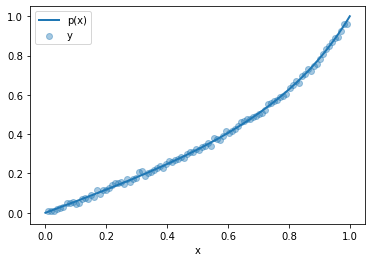

In [6]:
"""
Plot data
"""
fig, axs = plt.subplots(1, figsize=(6,4))
#axs.set_ylabel("p(x)")
axs.set_xlabel("x")
axs.scatter(PDE.data[:,0],PDE.data[:,1], label='y', alpha=0.4)
axs.plot(PDE.x, PDE.ptruth, label='p(x)', linewidth = 2)
axs.legend(loc="best")

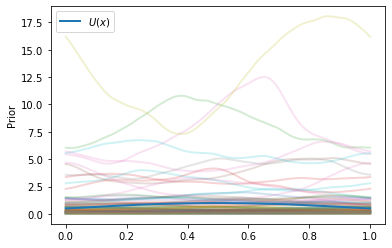

In [7]:
"""
Plot prior
"""
fig, axs = plt.subplots(1, figsize=(6,4))
axs.set_ylabel("Prior")
for i in range(100):
    xiu = np.random.normal(size=PDE.nPrior)
    u = lambda x: g(PDE.prior(x, xiu))
    axs.plot(PDE.x, u(PDE.x), alpha=0.2, linewidth=2)
axs.plot(PDE.x, PDE.U(PDE.x), label="$U(x)$", linewidth=2)
axs.legend(loc="best")#

In [9]:
"""
Run MCMC
"""
MCPDE = MC(negll=PDE.negll) # NLL for U
#xiu = np.random.normal(size=PDE.nPrior)
xiu = np.loadtxt('MAP10s19d100s3.out')

proba, results = MCPDE.MCMC(u0=xiu, h=0.05, n=200)

Running MCMC MH sampling
# of total samples:  200
Initial nll 39.69477935816026
draw no. 0 39.69477935816026
draw no. 1 39.69477935816026
draw no. 2 39.69477935816026
draw no. 3 39.69477935816026
draw no. 4 39.69477935816026
draw no. 5 39.69477935816026
draw no. 6 40.07541829520475
draw no. 7 40.07541829520475
draw no. 8 40.07541829520475
draw no. 9 40.07541829520475
draw no. 10 40.61098583101902
draw no. 11 40.61098583101902
draw no. 12 40.61098583101902
draw no. 13 40.61098583101902
draw no. 14 40.61098583101902
draw no. 15 40.61098583101902
draw no. 16 40.67970189380437
draw no. 17 40.67970189380437
draw no. 18 40.67970189380437
draw no. 19 40.67970189380437
draw no. 20 40.67970189380437
draw no. 21 40.67970189380437
draw no. 22 40.67970189380437
draw no. 23 40.67970189380437
draw no. 24 40.67970189380437
draw no. 25 40.361126521591224
draw no. 26 40.361126521591224
draw no. 27 40.361126521591224
draw no. 28 40.361126521591224
draw no. 29 40.361126521591224
draw no. 30 40.3611265215

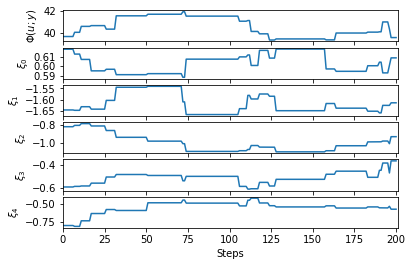

In [11]:
"""
Plot and postprocess MCMC results
"""
plot_results(results)

burn = 20
keep = post_results(results, burn, 1)
#np.savetxt('MAP10s19d100s3.out', MAP)

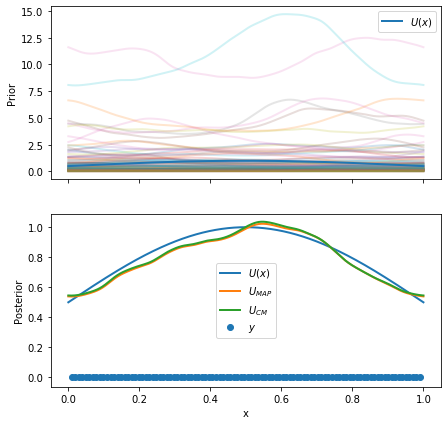

In [12]:
"""
Plot U
"""
u_ini = lambda x: g(PDE.prior(x, xiu))

MAP = keep_MAP(keep)
u_MAP = lambda x: g(PDE.prior(x, MAP))

fig, axs = plt.subplots(2, figsize=(7,7), sharex=True)
axs[0].set_ylabel("Prior")
for i in range(100):
    xiu = np.random.normal(size=PDE.nPrior)
    u = lambda x: g(PDE.prior(x, xiu))
    axs[0].plot(PDE.x, u(PDE.x), alpha=0.2, linewidth=2)
axs[0].plot(PDE.x, PDE.U(PDE.x), label="$U(x)$", linewidth=2)
axs[0].legend(loc="best")

axs[1].set_ylabel("Posterior")
axs[1].set_xlabel("x")
axs[1].plot(PDE.x, PDE.U(PDE.x), label="$U(x)$", linewidth=2)
axs[1].plot(PDE.x, u_MAP(PDE.x), label="$U_{MAP}$", linewidth=2)
axs[1].plot(PDE.x, u_CM(PDE.x), label="$U_{CM}$", linewidth=2)
#axs[1].plot(PDE.x, u_ini(PDE.x), label="$U_{ini}$", linewidth=2)
axs[1].scatter(PDE.data[:, 0], np.zeros(PDE.data.shape[0]), label="$y$")
#for i in range(keep.shape[0]):
#    xiu = BetaExp(keep[i, 1:], PDE.beta)
#    u = lambda x: g(PDE.prior(x, xiu)) * hh(x) #(1-np.exp(x-1))
#    axs[1].plot(PDE.x, u(PDE.x), alpha=0.2)
axs[1].legend(loc="best")
plt.show()

#print(MAP)